# Capstone Project - The Battle of the Neighborhoods (Week 5)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be addressed to interested parties interested in opening an **electronics store** in **Toronto**, Canada.

As there are many electronics stores in Toronto, we will try to detect places that are not yet full of stores. We are also especially interested in areas without nearby electronics stores. We also prefer that we have found as close as possible to the city center, assuming that the first two conditions are met.

We will use our data science powers to generate some more promising neighborhoods detected in this criterion. The advantages of each area will be clearly identified so that stakeholders can choose the best possible final location.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing electronic store in the neighborhood
* number of and distance to Electronic store in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Page Wikipedia**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Berlin city center.

Let's first find the latitude & longitude of Berlin city center, using specific, well known address and Google Maps geocoding API.

In [3]:
#!pip install bs4
#!pip install shapely
#!pip install geocoder
#!pip install pyproj

In [144]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup

import shapely.geometry
import pyproj
import math

from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries imported.')


Libraries imported.


### Download and Explore Dataset

Use the Beautiful Soup for extract HTML.

In [6]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_url)
#print(soup.prettify())


Extract Table with Postal Code.


In [7]:
My_table = soup.find('table',{'class':'wikitable sortable'})

#### Tranform the data into a *pandas* dataframe
Get Table to Dataframe and Unassigned checks are made in Borough and Neighborhood

Clean Data Frame :)

In [8]:
Head = My_table.find_all('tr')
Table = []
for th in Head:
    row = np.array(th.getText()[1:-1].split('\n'))
    if row[1] != 'Not assigned': 
        if row[2] == 'Not assigned':
            row[2] = row[1]
        Table.append(row)
        
df_Canada = pd.DataFrame(data=Table[1:], columns=Table[0])
df_Canada.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


### Transform Dataset

Get Name Columns

In [9]:
Col = df_Canada.columns

Group the neighborhood by Postcode

In [10]:
Col = df_Canada.columns
df_Canada_Group = df_Canada.groupby(Col[0])[Col[2]].apply(lambda x: ''.join([str(elem+',') for elem in list(x)])).reset_index()
df_Canada_Group.head()

,Postcode,Neighborhood
0,M1B,"Rouge,Malvern,"
1,M1C,"Highland Creek,Rouge Hill,Port Union,"
2,M1E,"Guildwood,Morningside,West Hill,"
3,M1G,"Woburn,"
4,M1H,"Cedarbrae,"


Then let's loop through the data and fill the dataframe one row at a time.

In [11]:
df_repeated = df_Canada.sort_values('Postcode', ascending=True)
df_repeated.drop_duplicates('Postcode', keep="last", inplace=True)
df_Canada_Group['Borough'] = df_repeated.reset_index()['Borough']

In [12]:
df_Canada_Group.head()

,Postcode,Neighborhood,Borough
0,M1B,"Rouge,Malvern,",Scarborough
1,M1C,"Highland Creek,Rouge Hill,Port Union,",Scarborough
2,M1E,"Guildwood,Morningside,West Hill,",Scarborough
3,M1G,"Woburn,",Scarborough
4,M1H,"Cedarbrae,",Scarborough


### Geospatial data

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

For your convenience, I downloaded the files and placed it on the server, so you can simply run a `wget` command and access the data. So let's go ahead and do that.

In [13]:
!wget -q -O 'postal_data.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [14]:
df_csv = pd.read_csv('postal_data.csv')
df_csv.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
df_Canada_Group['Latitude'] = df_csv['Latitude']
df_Canada_Group['Longitude'] = df_csv['Longitude']
df_Canada_Group.head()

,Postcode,Neighborhood,Borough,Latitude,Longitude
0,M1B,"Rouge,Malvern,",Scarborough,43.806686,-79.194353
1,M1C,"Highland Creek,Rouge Hill,Port Union,",Scarborough,43.784535,-79.160497
2,M1E,"Guildwood,Morningside,West Hill,",Scarborough,43.763573,-79.188711
3,M1G,"Woburn,",Scarborough,43.770992,-79.216917
4,M1H,"Cedarbrae,",Scarborough,43.773136,-79.239476


### Visualization

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

#### Use geopy library to get the latitude and longitude values of Toronto.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>tr_explorer</em>, as shown below.

In [47]:
address = 'downtown,Toronto'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude_Center = location.latitude
longitude_Center = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude_Center, longitude_Center))

The geograpical coordinate of Toronto City are 43.6563221, -79.3809161.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [48]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude_Center, longitude_Center], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Canada_Group['Latitude'], df_Canada_Group['Longitude'], df_Canada_Group['Borough'], df_Canada_Group['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='#5A99A2',
        fill=True,
        fill_color='#3AC2CE',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

Let's get the geographical coordinates of Scarborough.

In [49]:
address = 'Downtown,Toronto'

geolocator = Nominatim(user_agent="sb_explorer")
location = geolocator.geocode(address)
latitude_Center = location.latitude
longitude_Center = location.longitude
print('The geograpical coordinate of DownTown are {}, {}.'.format(latitude_Center, longitude_Center))

The geograpical coordinate of DownTown are 43.6563221, -79.3809161.


As we did with all of Scarborough, let's visualizat Scarborough the neighborhoods in it.

In [195]:
folium.Marker(
    location=[latitude_Center, longitude_Center],
    popup='Downtown - Toronto',
    icon=folium.Icon(color='gray', icon='info-sign')
).add_to(map_toronto)
map_toronto

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Downtown Toronto. So let's slice the original dataframe and create a new dataframe of the Downtown Toronto data.

In [20]:
Downtown_data = df_Canada_Group[df_Canada_Group['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
Downtown_data.head()

,Postcode,Neighborhood,Borough,Latitude,Longitude
0,M4W,"Rosedale,",Downtown Toronto,43.679563,-79.377529
1,M4X,"Cabbagetown,St. James Town,",Downtown Toronto,43.667967,-79.367675
2,M4Y,"Church and Wellesley,",Downtown Toronto,43.665860,-79.383160
3,M5A,"Harbourfront,",Downtown Toronto,43.654260,-79.360636
4,M5B,"Ryerson,Garden District,",Downtown Toronto,43.657162,-79.378937


In [21]:
# define the dataframe columns
column_names = ['Postcode', 'Borough', 'Neighbourhood','Latitude','Longitude']

# instantiate the dataframe
neighborhoods_Downtown = pd.DataFrame(columns=column_names)

# Iteración por filas del DataFrame:
for idx_row, row in Downtown_data.iterrows():
    Postal_Code = row[0]
    Borough = row[2]
    Latitude = row[3]
    Longitude = row[4]
    for Neighbourhood in row[1].split(','):
        if Neighbourhood !='':
            neighborhoods_Downtown = neighborhoods_Downtown.append({'Postcode':Postal_Code,'Borough':Borough,'Neighbourhood':Neighbourhood,
                                                            'Latitude':Latitude,'Longitude':Longitude}, ignore_index=True)
neighborhoods_Downtown.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,Cabbagetown,43.667967,-79.367675
2,M4X,Downtown Toronto,St. James Town,43.667967,-79.367675
3,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636


Correct neighborhood location (Latitude and Longitude)

In [22]:
Changes = [('Stn A PO Boxes 25 The Esplanade','Toronto Station'),
           ('Underground city','Queen'),
           ('Richmond','Richmond St W'),
           ('South Niagara','Niagara'),
           ('Railway Lands','108-120 Front St W')]
for change in Changes:
    neighborhoods_Downtown.loc[neighborhoods_Downtown.loc[:, 'Neighbourhood']==change[0],'Neighbourhood'] = change[1]
    print(' .', end='')
print(' Correction done.')

 . . . . . Correction done.


In [23]:
# Iteración por filas del DataFrame:
for idx_row, row in neighborhoods_Downtown.iterrows():
    address = str(row[2])+',Toronto, Ontario'
    geolocator = Nominatim(user_agent="sb_explorer")
    location = geolocator.geocode(address)
    neighborhoods_Downtown.loc[idx_row,'Latitude'] = location.latitude
    neighborhoods_Downtown.loc[idx_row,'Longitude'] = location.longitude
    #print('The geograpical coordinate of {} are {}, {}.'.format(address,location.latitude, location.longitude))
    

As we did with all of Scarborough, let's visualizate Downtown the neighborhoods in it.

In [197]:
# create map of Toronto using latitude and longitude values
map_Downtown = folium.Map(location=[latitude_Center, longitude_Center], zoom_start=12)

# add markers to map
for lat, lng, label in zip(neighborhoods_Downtown['Latitude'], neighborhoods_Downtown['Longitude'], neighborhoods_Downtown['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#5A99A2',
        fill=True,
        fill_color='#3AC2CE',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Downtown)  
    
map_Downtown

## Methodology <a name="methodology"></a>

In this project, we will direct our efforts to detect areas of downtown Toronto that have low store density, particularly those with a low number of stores
of electronics. We will limit our analysis to the area ~ 6 km around the city center of Toronto.

In the first step, we have collected the required data: location and type (category) of each restaurant less than 6 km from the center of Toronto. We have also identified stores (according to the Foursquare categorization).

The second step in our analysis will be the calculation and exploration of 'store density' in different areas of Toronto: we will use heat maps to identify some promising areas near the center with a low number of stores in general (and there are no stores of electronics nearby) and we focus our attention on those areas.

In the third and final step, we will focus on the most promising areas and within them we will create groups of locations that meet some basic requirements established in the discussion with stakeholders: we will consider locations with no more than two restaurants in a radius of 250 meters, and wants locations without electronic stores within a radius of 500 meters. We will present a map of all those locations, but we will also create groups (using the k-media grouping) of those locations to identify areas / neighborhoods / general addresses that should be a starting point for the final exploration of the 'street level' and look for the optimal location of the place by interested parties

## Analysis <a name="analysis"></a>

#### Define Foursquare Credentials and Version

In [82]:
CLIENT_ID = '414XZANJAD1HTUW5OGCCVYVBZINSZMLI1TLOP4HRLMSLV1M3' # your Foursquare ID
CLIENT_SECRET = '4Z4UIKJKZEXQ30I05L0JY1YM4GXYD3OD22IPCJ33P4DX2GPU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
QUERY = 'Store'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 414XZANJAD1HTUW5OGCCVYVBZINSZMLI1TLOP4HRLMSLV1M3
CLIENT_SECRET:4Z4UIKJKZEXQ30I05L0JY1YM4GXYD3OD22IPCJ33P4DX2GPU


## Explore Neighborhoods in Downtown Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Downtown Toronto

In [83]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,search_query=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       #print(name)
        print(' .', end='')    
        # create the API request URL
        # create URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            search_query,
            lat, 
            lng, 
            radius, 
            20)
        #print(url)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *Downtown_venues*.

In [84]:
# type your answer here

Downtown_venues = getNearbyVenues(names=neighborhoods_Downtown['Neighbourhood'],
                                   latitudes=neighborhoods_Downtown['Latitude'],
                                   longitudes=neighborhoods_Downtown['Longitude'],
                                   search_query=QUERY
                                  )

print(' done.')

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


#### Let's check the size of the resulting dataframe

In [85]:
print(Downtown_venues.shape)
Downtown_venues.head()

(499, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cabbagetown,43.664473,-79.366986,Fair Trade Jewellery Co.,43.665348,-79.368362,Jewelry Store
1,Cabbagetown,43.664473,-79.366986,Labour Of Love,43.663907,-79.368822,Gift Shop
2,Cabbagetown,43.664473,-79.366986,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
3,Cabbagetown,43.664473,-79.366986,No Frills,43.663515,-79.367166,Grocery Store
4,Cabbagetown,43.664473,-79.366986,Spruce,43.663614,-79.367607,Furniture / Home Store


#### Let's find out how many unique categories can be curated from all the returned venues

In [86]:
print('There are {} uniques categories.'.format(len(Downtown_venues['Venue Category'].unique())))

There are 76 uniques categories.


#### Heat map for stores (General) in downtown toronto

A heat map is a two-dimensional representation of data in which the values are represented by colors. A heat map provides a visual summary of the information we want to represent. Thus heat maps allow to understand quite complex data sets.

In [105]:
def generateBaseMap(default_location=[latitude_Center, longitude_Center], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

Downtown_venues['count'] = 1
DowntownHeat_map = generateBaseMap()
data_HeatMap = Downtown_venues[['Venue Latitude', 'Venue Longitude', 'count']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist()
HeatMap(data=data_HeatMap, radius=9, max_zoom=13).add_to(DowntownHeat_map)


In [106]:
folium.Marker(
    location=[latitude_Center, longitude_Center],
    popup='Downtown - Toronto',
    icon=folium.Icon(color='gray', icon='info-sign')
).add_to(DowntownHeat_map)
DowntownHeat_map

Signaling of potential locations from the heat map.

In [124]:
DowntownHeat_map_Locations = DowntownHeat_map
DowntownHeat_map_Locations.add_child(folium.ClickForMarker(popup='Potential Location'))

<a id='item3'></a>

## Analyze Each Neighborhood

In [108]:
# one hot encoding
Downtown_onehot = pd.get_dummies(Downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Downtown_onehot['Neighborhood'] = Downtown_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Downtown_onehot.columns[-1]] + list(Downtown_onehot.columns[:-1])
Downtown_onehot = Downtown_onehot[fixed_columns]


And let's examine the new dataframe size.

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [31]:
Downtown_grouped = Downtown_onehot.groupby('Neighborhood').mean().reset_index()
Downtown_grouped.head()

,Neighborhood,Accessories Store,Airport,Aquarium,Art Gallery,Arts & Crafts Store,Bagel Shop,Bar,Baseball Stadium,Basketball Stadium,Bookstore,Boutique,Brewery,Bus Station,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Discount Store,Electronics Store,Farmers Market,Food & Drink Shop,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,General Travel,Gift Shop,Gourmet Shop,Grocery Store,Hardware Store,Health Food Store,Hobby Shop,Hotel,Ice Cream Shop,Indian Restaurant,Jewelry Store,Juice Bar,Lingerie Store,Liquor Store,Mattress Store,Men's Store,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Music Store,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Pet Store,Pharmacy,Pizza Place,Record Shop,Shoe Store,Shopping Mall,Smoke Shop,Sporting Goods Shop,Supermarket,Tea Room,Thai Restaurant,Thrift / Vintage Store,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Women's Store
0,108-120 Front St W,0.0,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0000,0.05,0.10,0.0,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.200,0.0,0.0500,0.0500,0.0,0.05,0.0,0.0000,0.0,0.00,0.00,0.0000,0.0,0.00,0.0,0.00,0.0,0.0,0.0500,0.0,0.0,0.0,0.1500,0.0,0.0,0.0,0.0,0.0,0.00,0.05,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.00,0.05,0.0,0.00,0.0000,0.0,0.05,0.0000,0.05,0.0,0.0,0.0,0.05,0.0,0.0,0.0,0.0
1,Adelaide,0.0,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0000,0.00,0.00,0.0,0.0000,0.0,0.0,0.05,0.0,0.0,0.0,0.0,0.40,0.000,0.0,0.0000,0.0000,0.1,0.00,0.1,0.0000,0.0,0.05,0.00,0.0000,0.0,0.05,0.0,0.05,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.00,0.00,0.0,0.05,0.0500,0.0,0.10,0.0000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,Bathurst Quay,0.0,0.0,0.0000,0.0,0.00,0.0,0.0000,0.0000,0.00,0.00,0.0,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.500,0.0,0.0000,0.0000,0.0,0.00,0.0,0.0000,0.0,0.00,0.00,0.0000,0.0,0.00,0.0,0.00,0.0,0.0,0.5000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.0,0.00,0.00,0.0,0.00,0.0000,0.0,0.00,0.0000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,Berczy Park,0.0,0.0,0.0000,0.0,0.05,0.0,0.0000,0.0000,0.00,0.05,0.0,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.05,0.150,0.0,0.0500,0.0500,0.0,0.10,0.0,0.0000,0.0,0.00,0.05,0.0000,0.0,0.00,0.0,0.00,0.0,0.0,0.1000,0.0,0.0,0.0,0.0500,0.0,0.0,0.0,0.0,0.0,0.05,0.05,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0000,0.1,0.05,0.00,0.0,0.00,0.0000,0.0,0.00,0.0000,0.05,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,CN Tower,0.0,0.0,0.0625,0.0,0.00,0.0,0.0625,0.0625,0.00,0.00,0.0,0.0625,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.125,0.0,0.0625,0.0625,0.0,0.00,0.0,0.0625,0.0,0.00,0.00,0.0625,0.0,0.00,0.0,0.00,0.0,0.0,0.0625,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0625,0.0,0.0,0.0,0.0625,0.0,0.00,0.00,0.0,0.00,0.0625,0.0,0.00,0.0625,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [32]:
Downtown_grouped.shape

(34, 77)

#### Let's print each neighborhood along with the top 5 most common venues

First, let's write a function to sort the venues in descending order.

In [53]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    shop_places = row_categories_sorted.index.values[0:num_top_venues]
    for counter in range(len(shop_places)):
       shop_places[counter] = shop_places[counter] + ' (' + str(row_categories_sorted[counter]*100) + '%)'
    
    return shop_places


Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [200]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Downtown_grouped['Neighborhood']

for ind in np.arange(Downtown_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Downtown_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,108-120 Front St W,Coffee Shop (20.0%),Hotel (15.0%),Bookstore (10.0%),Basketball Stadium (5.0%),Deli / Bodega (5.0%)
1,Adelaide,Clothing Store (40.0%),Cosmetics Shop (10.0%),Department Store (10.0%),Sporting Goods Shop (10.0%),Furniture / Home Store (5.0%)
2,Bathurst Quay,Grocery Store (50.0%),Coffee Shop (50.0%),Dessert Shop (0.0%),Comic Shop (0.0%),Concert Hall (0.0%)
3,Berczy Park,Coffee Shop (15.0%),Grocery Store (10.0%),Pet Store (10.0%),Deli / Bodega (10.0%),Clothing Store (5.0%)
4,CN Tower,Coffee Shop (12.5%),Shopping Mall (6.25%),Supermarket (6.25%),Dessert Shop (6.25%),Brewery (6.25%)


Let's perform some basic exploratory data analysis and derive some additional info from our raw data. First let's count the **number of stores in every area candidate**:

Now we only look at the electronic stores, so a calorie map will be plotted to visualize in the areas that there are more electronic stores (Direct Competition) and thus be able to choose the area correctly.

### Explore Neighborhoods in Downtown Toronto (Electronic Store)

#### Let's create a function to repeat the same process to all the neighborhoods in Downtown Toronto

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *Downtown_venues*.

In [72]:

QUERY = 'Electronic Store'

Downtown_venues_Elec = getNearbyVenues(names=neighborhoods_Downtown['Neighbourhood'],
                                   latitudes=neighborhoods_Downtown['Latitude'],
                                   longitudes=neighborhoods_Downtown['Longitude'],
                                   search_query=QUERY
                                  )

print(' done.')

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


#### Let's check the size of the resulting dataframe

In [73]:
print(Downtown_venues_Elec.shape)
Downtown_venues_Elec.head()

(265, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cabbagetown,43.664473,-79.366986,The Source,43.662910,-79.367202,Electronics Store
1,Cabbagetown,43.664473,-79.366986,Encore Cellular,43.664430,-79.367940,Electronics Store
2,Cabbagetown,43.664473,-79.366986,SAMDI Wooden Electronic Accessories Store,43.667530,-79.369247,Electronics Store
3,Cabbagetown,43.664473,-79.366986,oemai,43.667996,-79.369601,Electronics Store
4,St. James Town,43.669403,-79.372704,WIND Mobile,43.670189,-79.375969,Electronics Store


#### Heat map for electronics stores in downtown toronto

A heat map is a two-dimensional representation of data in which the values are represented by colors. A heat map provides a visual summary of the information we want to represent. Thus heat maps allow to understand quite complex data sets.

In [182]:

Downtown_venues_Elec['Electronics Stores'] = 1
DowntownHeat_map = generateBaseMap()
data_HeatMap = Downtown_venues_Elec[['Venue Latitude', 'Venue Longitude', 'Electronics Stores']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist()
HeatMap(data=data_HeatMap, radius=11, max_zoom=9).add_to(DowntownHeat_map)


In [201]:
folium.Marker(
    location=[latitude_Center, longitude_Center],
    popup='Downtown - Toronto',
    icon=folium.Icon(color='gray', icon='info-sign')
).add_to(DowntownHeat_map)
DowntownHeat_map

Signaling of potential locations from the heat map.

In [69]:
DowntownHeat_map_Locations = DowntownHeat_map
DowntownHeat_map_Locations.add_child(folium.ClickForMarker(popup='Potential Location'))

In [184]:
DowTown_Neig = Downtown_venues_Elec[['Neighborhood','Venue', 'Venue Category', 'Electronics Stores']]
DowTown_Neig = DowTown_Neig[DowTown_Neig['Venue Category'] == 'Electronics Store']
DowTown_Neig = DowTown_Neig.groupby(['Neighborhood']).sum().reset_index()

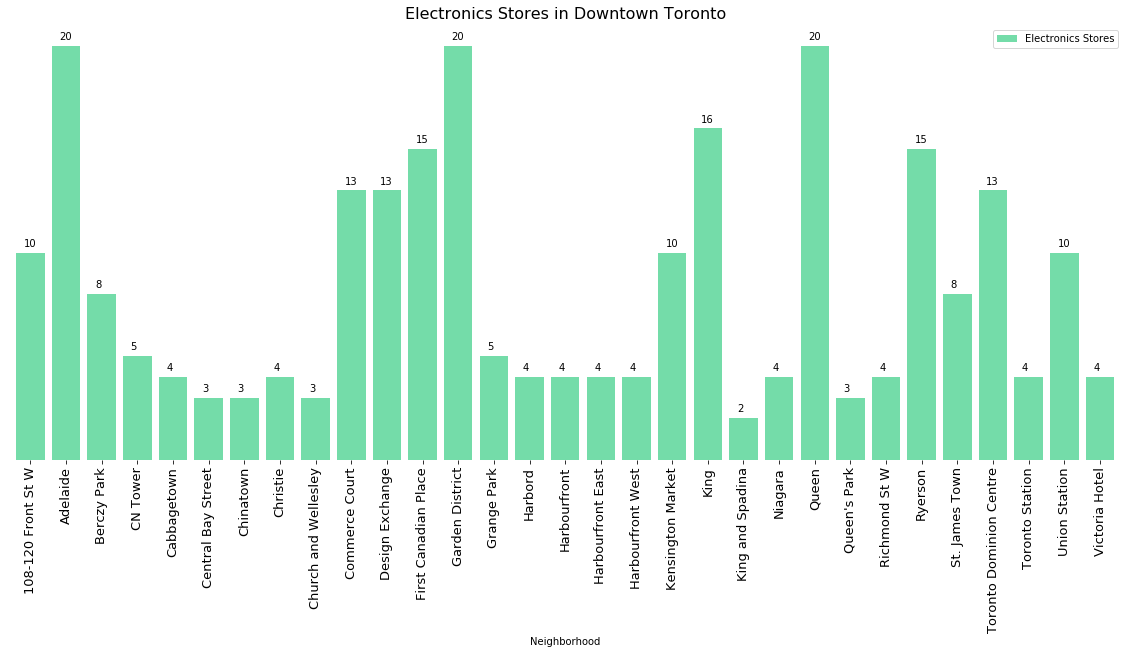

In [193]:
DowTown_Neig.index = DowTown_Neig['Neighborhood']

ax = DowTown_Neig.plot(kind='bar', figsize=(20, 8),width=0.8,color=('#74DCA9'),grid=False)
# Then we disable our xaxis and yaxis completely. If we just say plt.axis('off'),
# they are still used in the computation of the image padding.
ax.get_yaxis().set_visible(False)
ax.set_facecolor('#FFFFFF')
plt.title('Electronics Stores in Downtown Toronto',fontsize=16) # add title to the plot


plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])
# Add this loop to add the annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:}'.format(height), (x+0.212, y + height+0.3))
plt.show()


In [194]:
# create map of Toronto using latitude and longitude values

# add markers to map
for lat, lng, label in zip(neighborhoods_Downtown['Latitude'], neighborhoods_Downtown['Longitude'], neighborhoods_Downtown['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='#5A99A2',
        fill=True,
        fill_color='#3AC2CE',
        fill_opacity=0.7,
        parse_html=False).add_to(DowntownHeat_map)  
    
DowntownHeat_map

## Results and Discussion <a name="results"></a>

Our analysis shows that, although there are many electronics stores in Toronto (in our area of initial interest, which was 12x12 km around downtown Toronto), there are pockets of low-density electronics stores quite close to the city center. . The highest concentration of restaurants was detected in the north, east or south of downtown Toronto, so we focus our attention on the west, southeast, east and southwest areas, which correspond to the Rosedale, Niagara and Toronto Station districts. Another district was identified as potentially interesting (CN Tower, south of the city center), but we focus on Rosedale and Niagara, which offer a combination of popularity among tourists, proximity to the city center, strong socio-economic dynamics and A number of stores low density pockets.

After directing our attention to this narrowest area of interest (covering approximately 5x5 km south of the center), restaurants were first obtained near the center; those locations were filtered so that those with more than two stores within a radius of 150 m and those with an electronic store within 500 m were removed.

Those placement candidates were grouped together to create areas of interest that contain the largest number of placement candidates. The addresses of the centers in those areas were also generated using reverse geocoding to be used as markers / starting points for a more detailed local analysis based on other factors.

The result of all this is 6 zones that contain the greatest number of potential locations of new stores, depending on the number and distance to existing places, both stores in general and electronic stores in particular. This, of course, does not imply that these areas are really optimal locations for a new store! The purpose of this analysis was to provide information only on areas close to the center of Berlin but not full of existing stores (particularly electronic stores); It is quite possible that there is a very good reason for a small number of stores in any of those areas, reasons that would make them unsuitable for a new store, regardless of the lack of competition in the area. Therefore, the recommended areas should be considered only as a starting point for a more detailed analysis that could eventually result in a location that not only does not have close competition, but also other factors taken into account and all other relevant conditions compliments .
It is also seen that much of downtown Toronto is saturated with stores in general.

## Conclusion <a name="conclusion"></a>

The objective of this project was to identify the areas of Toronto near the center with a low number of stores (particularly electronics stores) to help interested parties reduce the search for an optimal location for a new electronics store; When calculating store density distribution from Foursquare data, we first identify general districts that warrant additional analysis (Rosedale and Niagara), and then generate a wide collection of locations that meet some basic requirements with respect to existing nearby stores . The grouping of these locations was then carried out to create the main areas of interest (containing the greatest number of potential locations) and the addresses of those zone centers were created to be used as starting points for the final exploration by the interested.

Interested parties will make the final decision on the optimal location of the store based on the specific characteristics of the neighborhoods and locations in each recommended area, taking into account additional factors such as the attractiveness of each location (proximity to the park or water), noise levels / proximity to main roads, availability of real estate, prices, social and economic dynamics of each neighborhood, etc.